In [ ]:
# Import packages
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, models, ops
from multiprocessing import cpu_count, Pool
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import pandas as pd
import librosa
import matplotlib.pyplot as plt

In [ ]:
#Setup Gdrive file download extention
!conda install -y gdown

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Retrieving notices: ...working... done
Channels:
 - rapidsai
 - nvidia
 - conda-forge
 - defaults
 - pytorch
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.7.4   |       hbcca054_0         151 KB  conda-forge
    certifi-2024.6.2           |     pyhd8ed1ab_0         157 KB  conda-forge
    filelock-3.15.4            |     pyhd8ed1ab_0          17 KB  conda-forge
    gdown-5.2.0                |     pyhd8ed1ab_0          21 KB  conda-forge
    openssl-3.3.1              |       h4ab18f5_1         2.8 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarc

In [ ]:
# Open google drive
!gdown  1dL5XQ-PCCekSL8PpRVkNElwSP9cB8NzP

Downloading...
From (original): https://drive.google.com/uc?id=1dL5XQ-PCCekSL8PpRVkNElwSP9cB8NzP
From (redirected): https://drive.google.com/uc?id=1dL5XQ-PCCekSL8PpRVkNElwSP9cB8NzP&confirm=t&uuid=6f047353-2829-48f4-9a94-e6b30a85e370
To: /kaggle/working/ESC-50-master.zip
100%|████████████████████████████████████████| 646M/646M [00:07<00:00, 81.0MB/s]


In [ ]:
# extract the files with the Dataset and useful information
!unzip /kaggle/working/ESC-50-master.zip

Archive:  /kaggle/working/ESC-50-master.zip
33c8ce9eb2cf0b1c2f8bcf322eb349b6be34dbb6
   creating: ESC-50-master/
   creating: ESC-50-master/.circleci/
  inflating: ESC-50-master/.circleci/config.yml  
   creating: ESC-50-master/.github/
  inflating: ESC-50-master/.github/stale.yml  
 extracting: ESC-50-master/.gitignore  
  inflating: ESC-50-master/LICENSE   
  inflating: ESC-50-master/README.md  
   creating: ESC-50-master/audio/
  inflating: ESC-50-master/audio/1-100032-A-0.wav  
  inflating: ESC-50-master/audio/1-100038-A-14.wav  
  inflating: ESC-50-master/audio/1-100210-A-36.wav  
  inflating: ESC-50-master/audio/1-100210-B-36.wav  
  inflating: ESC-50-master/audio/1-101296-A-19.wav  
  inflating: ESC-50-master/audio/1-101296-B-19.wav  
  inflating: ESC-50-master/audio/1-101336-A-30.wav  
  inflating: ESC-50-master/audio/1-101404-A-34.wav  
  inflating: ESC-50-master/audio/1-103298-A-9.wav  
  inflating: ESC-50-master/audio/1-103995-A-30.wav  
  inflating: ESC-50-master/audio/1-10

In [ ]:
batch_size=32
lr=0.001
experiment_name = 'Audio'

In [ ]:
# Initialize the dataframe with audio files specifications
df = pd.read_csv('/kaggle/working/ESC-50-master/meta/esc50.csv')
df

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [ ]:
import random
# Select 3 random unique indices
random_indices = random.sample(range(len(df)), 3)

# Initialize the figure with 3 rows and 3 columns
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10), sharex='col')

for i, idx in enumerate(random_indices):
    category = df.iloc[i]['category']
    y, sr = librosa.load(os.path.join('/kaggle/working/ESC-50-master/audio', df.iloc[idx]['filename']))
    y_resampled = librosa.resample(y, orig_sr=sr, target_sr=16000)

    # Waveform
    librosa.display.waveshow(y=y_resampled, sr=16000, ax=axes[i, 0])
    axes[i, 0].set(title=f'Waveform {category}')

    # Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y_resampled, sr=16000)
    img_spec = librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), y_axis='linear', x_axis='time', sr=16000, ax=axes[i, 1])
    axes[i, 1].set(title=f'Mel Spectrogram {category}')

    # MFCC
    mfcc = librosa.feature.mfcc(y=y_resampled, sr=16000, n_mfcc=40)
    img_mfcc = librosa.display.specshow(mfcc, y_axis='linear', x_axis='time', sr=16000, ax=axes[i, 2])
    axes[i, 2].set(title=f'MFCC {category}')

# Set the titles for the shared x-axis
axes[2, 0].set(xlabel='Time (s)')
axes[2, 1].set(xlabel='Time (s)')
axes[2, 2].set(xlabel='Time (s)')

# Set a title for the figure
fig.suptitle('Audio Analysis: Waveform, Mel Spectrogram, and MFCCs', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
class AudioDataset(data.Dataset):
    def __init__(self, root_dir, csv, sets, ms=3000, augmentations=None, transform=None):
        # save attributes
        self.root_dir = root_dir
        self.ms = ms
        # compute number of samples corresponding to self.ms milliseconds
        self.n_samples = int((16000 / 1000) * self.ms)
        # read csv file
        self.df = pd.read_csv(csv)
        # keep only the sets we are interested in
        self.df = self.df[self.df['fold'].isin(sets)]
        # augmentations
        self.augmentations = augmentations
        self.transform=transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # get filename, label, and category
        filename = self.df.iloc[index]['filename']
        label = self.df.iloc[index]['target']
        category = self.df.iloc[index]['category']
        # load audio file with librosa
        filename = os.path.join(self.root_dir, 'audio', filename)
        y, sr = librosa.load(filename)
        # convert to mono if needed
        if len(y.shape) > 1:
            y = librosa.to_mono(y)
        # resample to 16000 Hz
        if sr != 16000:
            y = librosa.resample(y, orig_sr=sr, target_sr=16000)
        # apply augmentations if any
        if self.augmentations:
            for augment in self.augmentations:
                y = augment(y, sr)

        # replicate if audio is too short
        if len(y) < self.n_samples:
            y = np.tile(y, self.n_samples // len(y) + 1)
        # random crop to self.n_samples
        isrt = np.random.randint(0, len(y) - self.n_samples)
        iend = isrt + self.n_samples
        y = y[isrt:iend]
        # compute win_length and hop_length for mfcc
        win_length = int((16000 / 1000) * 30)  # 30 ms
        hop_length = int((16000 / 1000) * 15)  # 15 ms
        # compute 40 MFCCs with previous parameters (n_mfcc=40)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40, win_length=win_length, hop_length=hop_length)
        mfcc = Image.fromarray(mfcc)

        # Data preprocessing
        if self.transform:
            mfcc = self.transform(mfcc)
        # return features and label
        return mfcc, label, category


In [ ]:
# Preparing the arrays for transfer learning
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])


In [ ]:
# Define augmentation functions
def time_stretch(y, rate):
    return librosa.effects.time_stretch(y, rate=rate)

def pitch_shift(y, sr, n_steps):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

def add_noise(y, noise_factor):
    noise = np.random.randn(len(y))
    augmented_data = y + noise_factor * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(y[0]))
    return augmented_data


In [ ]:
# Define a list of lambda functions to apply data augmentation
augmentations = [
    lambda y, sr: time_stretch(y, rate=random.uniform(0.8, 1.2)),
    lambda y, sr: pitch_shift(y, sr, n_steps=random.randint(-2, 2)),
    lambda y, sr: add_noise(y, noise_factor=random.uniform(0.001, 0.005))
]

In [ ]:
# test the dataset class
ds = AudioDataset('/kaggle/working/ESC-50-master', '/kaggle/working/ESC-50-master/meta/esc50.csv', [1,2,3,4,5], transform=transform)

mfcc, label, category = ds[5]

mfcc.shape

In [ ]:
# Create the datasets
train_ds = AudioDataset('/kaggle/working/ESC-50-master', '/kaggle/working/ESC-50-master/meta/esc50.csv', [1, 2, 3], transform=transform)
val_ds = AudioDataset('/kaggle/working/ESC-50-master', '/kaggle/working/ESC-50-master/meta/esc50.csv', [4], transform=transform)
test_ds = AudioDataset('/kaggle/working/ESC-50-master', '/kaggle/working/ESC-50-master/meta/esc50.csv', [5], transform=transform)


In [ ]:
# create train dataloader
train_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size = batch_size,
    drop_last = True,
    shuffle = True,
    num_workers = 2
)
# create validation dataloader
val_loader = torch.utils.data.DataLoader(
    val_ds,
    batch_size = 1,
    drop_last = False,
    shuffle = False,
    num_workers = 2
)

In [ ]:
# Check if GPU (Graphics Processing Unit) is available for training
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# Define the device to use for training based on GPU availability
device = torch.device("cuda:0" if train_on_gpu else "cpu")

# Print the chosen device for training
print(device)

In [ ]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F

# Load the MobileNetV2 model with pre-trained weights
net = torchvision.models.mobilenet_v2(weights='IMAGENET1K_V1')

# Get the number of features for the classifier input
num_ftrs = net.classifier[1].in_features

# Define the classifier
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(num_ftrs, 500)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(500, 251)
        self.fc3 = nn.Linear(251, 50)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.dropout(x)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

# Replace the classifier with the new classifier
net.classifier = Classifier()

# Check the updated model structure
print(net)

# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
audionet = net.to(device)

!pip install torchsummary
from torchsummary import summary
# Print model summary
summary(audionet, (3, 256, 256))  # Input shape (channels, height, width)
# Create a random input tensor with 1 channel, 40 frequency bins, and 301 time frames
inp = torch.rand(10, 3, 256, 256).to(device)

# Forward pass through the network
out = audionet(inp)

# Print the output shape and the output tensor
print(out.shape)
print(out)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 98.8MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
             ReLU6-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
             ReLU6-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 16, 128, 128]             512
       BatchNorm2d-8         [-1, 16, 128, 128]              32
  InvertedResidual-9         [-1, 16, 128, 128]               0
           Conv2d-10         [-1, 96, 128, 128]           1,536
      BatchNorm2d-11         [-1, 96, 128, 128]             192
            ReLU6-12         [-1, 96, 128, 128]               0
           Conv2d-13           [-1, 96, 64, 64]             864
      BatchNorm2d-14           [-1, 96,

In [ ]:
# Freeze pre-trained layers and unfreeze the classifier for fine-tuning
for key, value in dict(audionet.named_children()).items():
    if "classifier" in key:
        for param in value.parameters():
            param.requires_grad = True
            print(f"Unfreezing layer: {key}, Parameter shape: {param.shape}")  # Print unfrozen layers (classifier)
    else:
        for param in value.parameters():
            param.requires_grad = False

Unfreezing layer: classifier, Parameter shape: torch.Size([500, 1280])
Unfreezing layer: classifier, Parameter shape: torch.Size([500])
Unfreezing layer: classifier, Parameter shape: torch.Size([251, 500])
Unfreezing layer: classifier, Parameter shape: torch.Size([251])
Unfreezing layer: classifier, Parameter shape: torch.Size([50, 251])
Unfreezing layer: classifier, Parameter shape: torch.Size([50])


In [ ]:
import torch.optim as optim  # Optimization algorithms for training the model
import torch.nn.functional as F  # Common loss functions and activation functions
import itertools  # Utility functions for generating combinations
from torch.optim.lr_scheduler import CosineAnnealingLR  # Learning rate scheduler for training
import matplotlib.pyplot as plt  # Plotting library for visualization


# Define training parameters (epochs, loss function, optimizer, and scheduler)
epochs = 100  # Number of training epochs
criterion = nn.CrossEntropyLoss()  # Crossentropyloss function for classification
optimizer = optim.Adam(audionet.parameters(), lr=0.0001)  # Adam optimizer with learning rate 0.001
scheduler = CosineAnnealingLR(optimizer,
                              T_max=len(train_loader) * epochs,  # Maximum number of iterations for scheduler
                              eta_min=1e-8)  # Minimum learning rate for scheduler

In [ ]:
best_val_loss = float('inf') # Initialize the validation loss
patience = 10 # Initialize the patience level
patience_counter = 0 # Initialize the counter

for epoch in range(epochs):
    # Initialize Running loss, ground truth labels and predictions
    running_loss = []
    gt = []
    pred = []

    # Set the network in training mode
    audionet.train()

    for i, inp in enumerate(train_loader):
        inputs, labels, _ = inp
        gt.append(labels.cpu().numpy())   # Append ground truth

        inputs = inputs.to(device)  # Move data to the appropriate device (CPU or GPU)
        labels = labels.to(device)  # Move labels to the appropriate device

        # Zero the parameter gradients before each backward pass
        optimizer.zero_grad()

        # Forward pass, calculate loss
        outputs = audionet(inputs)
        loss = criterion(outputs, labels.view(-1))
        pred.append(torch.max(outputs.cpu(), 1)[1])

        # Backward pass and parameter update
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model weights based on gradients
        scheduler.step()  # Update learning rate according to the scheduler

        # Print statistics (every 10% of the training data)
        running_loss.append(loss.item())
        if (i + 1) % (len(train_loader) // 10) == 0:  # Every 10% of the epoch
            gt = np.stack(list(itertools.chain.from_iterable(gt))).squeeze()  # Combine ground truth labels
            pred = np.stack(list(itertools.chain.from_iterable(pred))).squeeze()  # Combine predictions
            acc = np.sum(gt==pred)/len(gt)
            print('%d, [%d, %d] loss: %.4f\tAccuracy: %.3f\tlr: %.6f' %
                      (epoch + 1, i + 1, len(train_loader), np.mean(running_loss), acc, optimizer.param_groups[-1]['lr']))

            running_loss = []
            gt = []
            pred = []

    # Validation loop (after each training epoch)
    running_loss = []  # List to store validation loss for each batch
    gt = []  # List to store ground truth labels (predicted age)
    pred = []  # List to store predicted labels (model output)

    audionet.eval()  # Set the model to evaluation mode (deactivates dropout and other training behaviors)

    for i, data in enumerate(val_loader):
        # Get inputs and labels from the data loader
        inputs, labels, _ = data
        gt.append(labels.item())  # Append ground truth as single values

        inputs = inputs.to(device)  # Move data to the appropriate device
        labels = labels.to(device)  # Move labels to the appropriate device

        # Forward pass with gradient suppression
        with torch.no_grad():
            outputs = audionet(inputs)  # Get model predictions without calculating gradients

        pred.append(torch.max(outputs.cpu(), 1)[1])
        loss = criterion(outputs, labels)
        running_loss.append(loss.item())

    # Calculate and print validation performance metrics
    gt = np.stack(list(gt)).squeeze()
    pred = np.stack(list(pred)).squeeze()
    acc = np.sum(gt==pred)/len(gt)

    print(np.sum(gt==pred),len(gt))

    # Compute validation loss
    val_loss = np.mean(running_loss)
    print('Validation loss: %.6f\tAccuracy: %.3f' % (val_loss, acc))

    # Early stop of the train in case of 10 consecutive non-increasing in validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(audionet.state_dict(), "AudioNet.pth") # Save the best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch} due to no improvement in validation loss for {patience} epochs.")
            break

print('Finished Training')

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1, [3, 37] loss: 3.9095	Accuracy: 0.010	lr: 0.000100
1, [6, 37] loss: 3.9189	Accuracy: 0.021	lr: 0.000100
1, [9, 37] loss: 3.9350	Accuracy: 0.031	lr: 0.000100
1, [12, 37] loss: 3.9145	Accuracy: 0.042	lr: 0.000100
1, [15, 37] loss: 3.9170	Accuracy: 0.042	lr: 0.000100
1, [18, 37] loss: 3.9030	Accuracy: 0.021	lr: 0.000100
1, [21, 37] loss: 3.9145	Accuracy: 0.031	lr: 0.000100
1, [24, 37] loss: 3.9139	Accuracy: 0.000	lr: 0.000100
1, [27, 37] loss: 3.9037	Accuracy: 0.000	lr: 0.000100
1, [30, 37] loss: 3.8906	Accuracy: 0.042	lr: 0.000100
1, [33, 37] loss: 3.9015	Accuracy: 0.031	lr: 0.000100
1, [36, 37] loss: 3.9130	Accuracy: 0.042	lr: 0.000100


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


9 400
Validation loss: 3.908910	Accuracy: 0.022
2, [3, 37] loss: 3.9070	Accuracy: 0.010	lr: 0.000100
2, [6, 37] loss: 3.9098	Accuracy: 0.042	lr: 0.000100
2, [9, 37] loss: 3.8925	Accuracy: 0.021	lr: 0.000100
2, [12, 37] loss: 3.8973	Accuracy: 0.052	lr: 0.000100
2, [15, 37] loss: 3.8885	Accuracy: 0.031	lr: 0.000100
2, [18, 37] loss: 3.8899	Accuracy: 0.031	lr: 0.000100
2, [21, 37] loss: 3.9007	Accuracy: 0.052	lr: 0.000100
2, [24, 37] loss: 3.9070	Accuracy: 0.010	lr: 0.000100
2, [27, 37] loss: 3.9065	Accuracy: 0.010	lr: 0.000100
2, [30, 37] loss: 3.8971	Accuracy: 0.052	lr: 0.000100
2, [33, 37] loss: 3.8895	Accuracy: 0.083	lr: 0.000100
2, [36, 37] loss: 3.8832	Accuracy: 0.031	lr: 0.000100
27 400
Validation loss: 3.882170	Accuracy: 0.068
3, [3, 37] loss: 3.8613	Accuracy: 0.083	lr: 0.000100
3, [6, 37] loss: 3.8785	Accuracy: 0.052	lr: 0.000100
3, [9, 37] loss: 3.8883	Accuracy: 0.031	lr: 0.000100
3, [12, 37] loss: 3.8833	Accuracy: 0.052	lr: 0.000100
3, [15, 37] loss: 3.8635	Accuracy: 0.042	lr: 

In [ ]:
# Load the best model for fine-tuning
audionet = torchvision.models.mobilenet_v2(weights='IMAGENET1K_V1')
audionet.classifier = Classifier()
audionet.load_state_dict(torch.load('/kaggle/working/AudioNet.pth', map_location=device))
audionet.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
# Unfreeze all the layers for fine tuning
for key, value in dict(audionet.named_children()).items():
    for param in value.parameters():
        param.requires_grad = True
        print(f"Unfreezing layer: {key}, Parameter shape: {param.shape}")  # Print unfrozen layers (classifier)

Unfreezing layer: features, Parameter shape: torch.Size([32, 3, 3, 3])
Unfreezing layer: features, Parameter shape: torch.Size([32])
Unfreezing layer: features, Parameter shape: torch.Size([32])
Unfreezing layer: features, Parameter shape: torch.Size([32, 1, 3, 3])
Unfreezing layer: features, Parameter shape: torch.Size([32])
Unfreezing layer: features, Parameter shape: torch.Size([32])
Unfreezing layer: features, Parameter shape: torch.Size([16, 32, 1, 1])
Unfreezing layer: features, Parameter shape: torch.Size([16])
Unfreezing layer: features, Parameter shape: torch.Size([16])
Unfreezing layer: features, Parameter shape: torch.Size([96, 16, 1, 1])
Unfreezing layer: features, Parameter shape: torch.Size([96])
Unfreezing layer: features, Parameter shape: torch.Size([96])
Unfreezing layer: features, Parameter shape: torch.Size([96, 1, 3, 3])
Unfreezing layer: features, Parameter shape: torch.Size([96])
Unfreezing layer: features, Parameter shape: torch.Size([96])
Unfreezing layer: featu

In [ ]:
import torch.optim as optim  # Optimization algorithms for training the model
import torch.nn.functional as F  # Common loss functions and activation functions
import itertools  # Utility functions for generating combinations
from torch.optim.lr_scheduler import CosineAnnealingLR  # Learning rate scheduler for training
import matplotlib.pyplot as plt  # Plotting library for visualization


# Define training parameters (epochs, loss function, optimizer, and scheduler)
epochs = 100  # Number of training epochs
criterion = nn.CrossEntropyLoss()  # Crossentropyloss function for classification
optimizer = optim.Adam(audionet.parameters(), lr=0.0001)  # Adam optimizer with learning rate 0.001
scheduler = CosineAnnealingLR(optimizer,
                              T_max=len(train_loader) * epochs,  # Maximum number of iterations for scheduler
                              eta_min=1e-8)  # Minimum learning rate for scheduler

In [ ]:
best_val_loss = float('inf') # Initialize the validation loss
patience = 10 # Initialize the patience level
patience_counter = 0 # Initialize the counter

for epoch in range(epochs):
    # Initialize Running loss, ground truth labels and predictions
    running_loss = []
    gt = []
    pred = []

    # Set the network in training mode
    audionet.train()

    for i, inp in enumerate(train_loader):
        inputs, labels, _ = inp
        gt.append(labels.cpu().numpy())   # Append ground truth

        inputs = inputs.to(device)  # Move data to the appropriate device (CPU or GPU)
        labels = labels.to(device)  # Move labels to the appropriate device

        # Zero the parameter gradients before each backward pass
        optimizer.zero_grad()

        # Forward pass, calculate loss
        outputs = audionet(inputs)
        loss = criterion(outputs, labels.view(-1))
        pred.append(torch.max(outputs.cpu(), 1)[1])

        # Backward pass and parameter update
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model weights based on gradients
        scheduler.step()  # Update learning rate according to the scheduler

        # Print statistics (every 10% of the training data)
        running_loss.append(loss.item())
        if (i + 1) % (len(train_loader) // 10) == 0:  # Every 10% of the epoch
            gt = np.stack(list(itertools.chain.from_iterable(gt))).squeeze()  # Combine ground truth labels
            pred = np.stack(list(itertools.chain.from_iterable(pred))).squeeze()  # Combine predictions
            acc = np.sum(gt==pred)/len(gt)
            print('%d, [%d, %d] loss: %.4f\tAccuracy: %.3f\tlr: %.6f' %
                      (epoch + 1, i + 1, len(train_loader), np.mean(running_loss), acc, optimizer.param_groups[-1]['lr']))

            running_loss = []
            gt = []
            pred = []

    # Validation loop (after each training epoch)
    running_loss = []  # List to store validation loss for each batch
    gt = []  # List to store ground truth labels (predicted age)
    pred = []  # List to store predicted labels (model output)

    audionet.eval()  # Set the model to evaluation mode (deactivates dropout and other training behaviors)

    for i, data in enumerate(val_loader):
        # Get inputs and labels from the data loader
        inputs, labels, _ = data
        gt.append(labels.item())  # Append ground truth as single values

        inputs = inputs.to(device)  # Move data to the appropriate device
        labels = labels.to(device)  # Move labels to the appropriate device

        # Forward pass with gradient suppression
        with torch.no_grad():
            outputs = audionet(inputs)  # Get model predictions without calculating gradients

        pred.append(torch.max(outputs.cpu(), 1)[1])
        loss = criterion(outputs, labels)
        running_loss.append(loss.item())

    # Calculate and print validation performance metrics
    gt = np.stack(list(gt)).squeeze()
    pred = np.stack(list(pred)).squeeze()
    acc = np.sum(gt==pred)/len(gt)

    print(np.sum(gt==pred),len(gt))

    # Compute validation loss
    val_loss = np.mean(running_loss)
    print('Validation loss: %.6f\tAccuracy: %.3f' % (val_loss, acc))

    # Early stop of the train in case of 10 consecutive non-increasing in validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(audionet.state_dict(), "AudioNet.pth") # Save the best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch} due to no improvement in validation loss for {patience} epochs.")
            break

print('Finished Training')

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1, [3, 37] loss: 2.0741	Accuracy: 0.406	lr: 0.000100
1, [6, 37] loss: 2.3198	Accuracy: 0.406	lr: 0.000100
1, [9, 37] loss: 2.3831	Accuracy: 0.396	lr: 0.000100
1, [12, 37] loss: 2.2299	Accuracy: 0.365	lr: 0.000100
1, [15, 37] loss: 2.0716	Accuracy: 0.302	lr: 0.000100
1, [18, 37] loss: 2.2398	Accuracy: 0.344	lr: 0.000100
1, [21, 37] loss: 2.2859	Accuracy: 0.375	lr: 0.000100
1, [24, 37] loss: 2.2267	Accuracy: 0.333	lr: 0.000100
1, [27, 37] loss: 1.8342	Accuracy: 0.438	lr: 0.000100
1, [30, 37] loss: 2.2212	Accuracy: 0.365	lr: 0.000100
1, [33, 37] loss: 1.9032	Accuracy: 0.438	lr: 0.000100
1, [36, 37] loss: 1.9569	Accuracy: 0.469	lr: 0.000100


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


179 400
Validation loss: 2.068359	Accuracy: 0.448
2, [3, 37] loss: 2.0460	Accuracy: 0.385	lr: 0.000100
2, [6, 37] loss: 1.6455	Accuracy: 0.552	lr: 0.000100
2, [9, 37] loss: 1.8848	Accuracy: 0.531	lr: 0.000100
2, [12, 37] loss: 1.8312	Accuracy: 0.438	lr: 0.000100
2, [15, 37] loss: 1.6232	Accuracy: 0.521	lr: 0.000100
2, [18, 37] loss: 1.9488	Accuracy: 0.375	lr: 0.000100
2, [21, 37] loss: 1.8413	Accuracy: 0.500	lr: 0.000100
2, [24, 37] loss: 1.9436	Accuracy: 0.469	lr: 0.000100
2, [27, 37] loss: 1.9486	Accuracy: 0.427	lr: 0.000100
2, [30, 37] loss: 1.8122	Accuracy: 0.469	lr: 0.000100
2, [33, 37] loss: 1.7634	Accuracy: 0.479	lr: 0.000100
2, [36, 37] loss: 1.5726	Accuracy: 0.573	lr: 0.000100
194 400
Validation loss: 1.883613	Accuracy: 0.485
3, [3, 37] loss: 1.7835	Accuracy: 0.490	lr: 0.000100
3, [6, 37] loss: 1.6157	Accuracy: 0.510	lr: 0.000100
3, [9, 37] loss: 1.6002	Accuracy: 0.510	lr: 0.000100
3, [12, 37] loss: 1.8259	Accuracy: 0.469	lr: 0.000100
3, [15, 37] loss: 1.5913	Accuracy: 0.490	l

In [ ]:
# Load the best model for evaluation

audionet.load_state_dict(torch.load('/kaggle/working/AudioNet.pth', map_location=device))

<All keys matched successfully>

In [ ]:
# Initialize the test data loader
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=2)

In [ ]:
# Testing loop
running_loss = []  # List to store test loss for each batch
gt_labels = []  # List to store ground truth labels
pr_labels = []  # List to store predicted labels
top5_correct = 0  # Counter for top-5 accuracy

net.eval()  # Set the model to evaluation mode

for i, data in enumerate(test_loader):
    # Get inputs and labels from the data loader
    inputs, labels, _ = data
    gt_labels.append(labels.item())  # Append ground truth as single values

    inputs = inputs.to(device)  # Move data to the appropriate device (CPU or GPU)
    labels = labels.to(device)  # Move labels to the appropriate device

    # Forward pass with gradient suppression
    with torch.no_grad():
        outputs = audionet(inputs)  # Get model predictions without calculating gradients

    pr_labels.append(torch.max(outputs.cpu(), 1)[1])
    loss = criterion(outputs, labels.view(-1))
    running_loss.append(loss.item())

    # Calculate top-5 accuracy
    top5_preds = torch.topk(outputs, 5, dim=1).indices.cpu().numpy()
    if labels.cpu().numpy() in top5_preds:
        top5_correct += 1

# Calculate and print validation performance metrics
gt = np.stack(list(gt_labels)).squeeze()
pred = np.stack(list(pr_labels)).squeeze()
test_loss = np.mean(running_loss)

from sklearn.metrics import accuracy_score, precision_score, recall_score
acc = accuracy_score(gt, pred)
prec = precision_score(gt, pred, average='macro')
rec = recall_score(gt, pred, average='macro')
top5_acc = top5_correct / len(test_loader.dataset)

# Display the outcomes
print(f'Test loss: {test_loss:.6f}\t Accuracy: {acc:.3f}\tPrecision: {prec:.3f}\tRecall: {rec:.3f}\tTop-5 Accuracy: {top5_acc:.3f}')


Test loss: 1.839488	 Accuracy: 0.505	Precision: 0.490	Recall: 0.505	Top-5 Accuracy: 0.828


In [ ]:
# Create a list with the targets IN THE ORDER THEY APPEAR IN THE DATASET
indexes = np.unique(gt, return_index=True)[1]
classes = [gt[index] for index in sorted(indexes)]

# Create a list of sample class names
class_names = df['category'].unique()

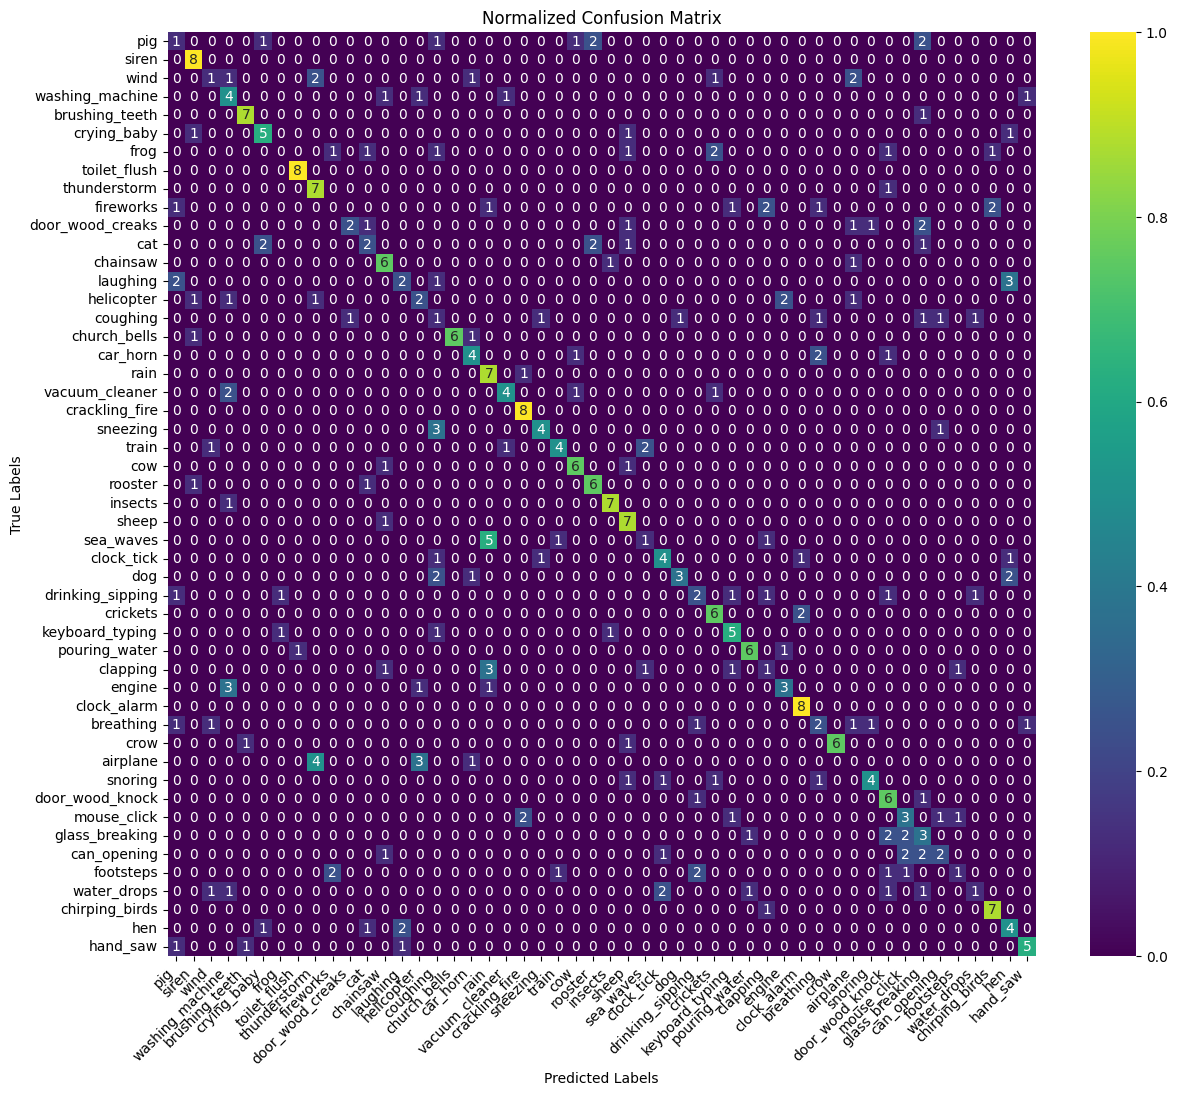

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Create a dictionary that maps numerical targets to class names
class_dict = {i: class_name for i, class_name in zip(classes, class_names)}

# Convert numerical targets to string class names
gt_str = [class_dict[i] for i in gt]
pred_str = [class_dict[i] for i in pred]

# Compute the confusion matrix
conf_mat = confusion_matrix(gt_str, pred_str, labels=class_names)

# Normalize the confusion matrix
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

# Plot the heatmap with annotations
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(conf_mat_normalized, annot=conf_mat, fmt='d', cmap='viridis', xticklabels=class_names, yticklabels=class_names)

# Customize the heatmap
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=10)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=10)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()